In [1]:
import time
import os
import copy
from collections import defaultdict

# deep learning/vision libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import cv2 as cv  # OpenCV

# numeric and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
from kard_data_loader import KardDataLoader
import consts as c

In [2]:
train = KardDataLoader('C:\\Users\\bozam\\Desktop\\KARD train test validation\\train\\')
train.getActivityData(c.FILETYPES['screen'])

In [3]:
test = KardDataLoader('C:\\Users\\bozam\\Desktop\\KARD train test validation\\test\\')
test.getActivityData(c.FILETYPES['screen'])

In [4]:
validation = KardDataLoader('C:\\Users\\bozam\\Desktop\\KARD train test validation\\validation\\')
validation.getActivityData(c.FILETYPES['screen'])

In [5]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [6]:
def make_training_set(data):
    generated_images = []
    generated_classes = []
    x = []
    y = []
    z = []
            
    for class_name in range(len(data)):
        image_sequence = []
        for people_sequences in range(len(data[class_name])):
            counter = 0
            for people_coordinates in data[class_name][people_sequences]:
                x.append(people_coordinates[0])
                y.append(people_coordinates[1])
                z.append(people_coordinates[2])
                counter += 1
                
                if counter == 15:
                    counter = 0
                    x = normalize(x)
                    
                    y = normalize(y)
                    
                    z = normalize(z)
                    
                    image_layer = [[x[i], y[i], z[i]] for i in range(15)]
                    generated_images.append(image_layer)
                    generated_classes.append(class_name)
                    x = []
                    y = []
                    z = []
            
    return generated_images, generated_classes

In [7]:
train_images, train_labels = make_training_set(train.data)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
validation_images, validation_labels = make_training_set(validation.data)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

In [9]:
test_images, test_labels = make_training_set(test.data)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [10]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [11]:
def make_images_compact(train_data, train_labels, batch_size, stride):
    batch_edges = [[a, a + batch_size] for a in range(0 , len(train_data) - batch_size, stride) if train_labels[a] == train_labels[a + batch_size]]
    
    batch_data = []
    batch_labels = []
    
    for (a, b) in (batch_edges):
        batch_data.append(train_data[a:b])
        batch_labels.append(train_labels[a])
    
    rnd_idx = np.random.permutation(len(batch_data))
    batch_data = np.array(batch_data)
    batch_labels = np.array(batch_labels)
    
    batch_data = batch_data[rnd_idx, :, :, :]
    batch_labels = batch_labels[rnd_idx]
    
    return (batch_data, batch_labels)

In [12]:
def make_batches(X_train, y_train, batch_size):
    n_batches = len(X_train) // batch_size
    indexes = np.array(list(range(0, len(X_train))))
    for batch_idx in np.array_split(indexes, n_batches):
        X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
        yield X_batch, y_batch

In [13]:
train_images_new, train_labels_new = make_images_compact(train_images, train_labels, 40, 3)

In [14]:
validation_images_new, validation_labels_new = make_images_compact(validation_images, validation_labels, 40, 3)

In [15]:
test_images_new, test_labels_new = make_images_compact(test_images, test_labels, 40, 3)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
def train_model(model, criterion, optimizer, num_epochs=100):
    
    metrics = defaultdict(list)
    best_acc = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', "val"]:
            if phase == 'train':
                model.train()  # Set model to training mode
                data = train_images_new
                labels = train_labels_new
            else:
                model.eval()   # Set model to evaluate mode
                data = validation_images_new
                labels = validation_labels_new
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # 40, 15, 3 - > 3, 15, 40
            #print(np.array(train_images).shape)
            #print(np.array(train_labels).shape)
            for (inputs, labels) in make_batches(data, labels, 40):
                #print(np.array(inputs).shape)
                #inputs = inputs.reshape(3, 15, 41)
                inputs = inputs.reshape(-1, 3, 15, 40)
                inputs = torch.from_numpy(inputs)
                labels = torch.from_numpy(np.array([labels]))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                #print("Pre setovanja gradienata!")
                with torch.set_grad_enabled(phase == 'train'):
                    #print("Ulazim u setovanje gradienata!!!!")
                    outputs = model(inputs.float())
                    
                    _, preds = torch.max(outputs, 1)
                    labels = labels.view(-1)
                    loss = criterion(outputs, labels.long())
                    #print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
            
            epoch_loss = running_loss / len(data)
            epoch_acc = float(running_corrects) / len(data)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            metrics[phase+"_loss"].append(epoch_loss)
            metrics[phase+"_acc"].append(epoch_acc)

    return metrics

In [20]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        num_of_channels = [3, 16, 32, 48]
        kernel_sizes = [3, 3, 3, 3]
        stride_sizes = [2, 2, 2, 2]
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = nn.Conv2d(num_of_channels[0], num_of_channels[1], kernel_size=(2, 2), stride=stride_sizes[0])
        self.bn1 = nn.BatchNorm2d(num_of_channels[1])
        self.conv2 = nn.Conv2d(num_of_channels[1], num_of_channels[2], kernel_size=(2, 2), stride=stride_sizes[1])
        self.bn2 = nn.BatchNorm2d(num_of_channels[2])
        self.conv3 = nn.Conv2d(num_of_channels[2], num_of_channels[3], kernel_size=(2, 2), stride=stride_sizes[2])
        self.bn3 = nn.BatchNorm2d(num_of_channels[3])
        #self.conv4 = nn.Conv2d(num_of_channels[3], num_of_channels[4], kernel_size=(2, 3), stride=stride_sizes[3])
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Linear(num_of_channels[-1] * 7 * 7, 18)
        
        
    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.bn1(y)
        y = self.relu(self.conv2(y))
        y = self.bn2(y)
        y = self.relu(self.conv3(y))
        y = self.bn3(y)
       # y = self.relu(self.conv4(y))
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        
        return y
    
    
custom_cnn = CustomCNN().to(device)
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, custom_cnn.parameters()), lr = 0.0001)

print(f"number of params in model {count_parameters(custom_cnn)}")

criterion = nn.CrossEntropyLoss()
metrics = train_model(custom_cnn, criterion, optimizer_conv, num_epochs=100)

number of params in model 51026
Epoch 0/99
----------
train Loss: 2.7061 Acc: 0.1646
val Loss: 2.4138 Acc: 0.3158
Epoch 1/99
----------
train Loss: 2.2858 Acc: 0.3720
val Loss: 2.0227 Acc: 0.4372
Epoch 2/99
----------
train Loss: 2.0144 Acc: 0.4591
val Loss: 1.7542 Acc: 0.5223
Epoch 3/99
----------
train Loss: 1.8186 Acc: 0.5124
val Loss: 1.5613 Acc: 0.5749
Epoch 4/99
----------
train Loss: 1.6703 Acc: 0.5508
val Loss: 1.4179 Acc: 0.6154
Epoch 5/99
----------
train Loss: 1.5550 Acc: 0.5774
val Loss: 1.3077 Acc: 0.6356
Epoch 6/99
----------
train Loss: 1.4624 Acc: 0.5985
val Loss: 1.2209 Acc: 0.6538
Epoch 7/99
----------
train Loss: 1.3859 Acc: 0.6152
val Loss: 1.1500 Acc: 0.6640
Epoch 8/99
----------
train Loss: 1.3212 Acc: 0.6316
val Loss: 1.0906 Acc: 0.6842
Epoch 9/99
----------
train Loss: 1.2655 Acc: 0.6471
val Loss: 1.0405 Acc: 0.6923
Epoch 10/99
----------
train Loss: 1.2168 Acc: 0.6588
val Loss: 0.9976 Acc: 0.7085
Epoch 11/99
----------
train Loss: 1.1737 Acc: 0.6693
val Loss: 0

train Loss: 0.4010 Acc: 0.8855
val Loss: 0.4660 Acc: 0.8482


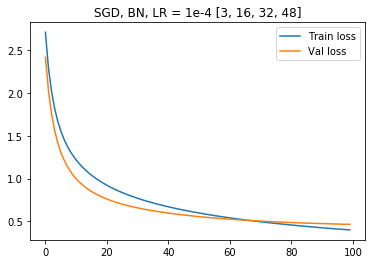

In [21]:
plt.plot(list(range(0, len(metrics["train_loss"]))), metrics["train_loss"], label = "Train loss")
plt.plot(list(range(0, len(metrics["val_loss"]))), metrics["val_loss"], label = "Val loss")
plt.legend()
plt.title("SGD, BN, LR = 1e-4 [3, 16, 32, 48]")
plt.savefig("Images/15")

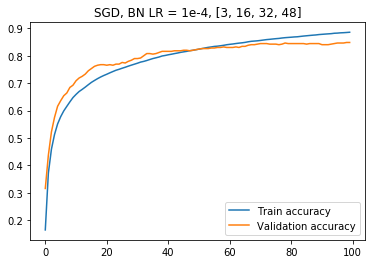

In [22]:
plt.plot(list(range(0, len(metrics["train_acc"]))), metrics["train_acc"], label = "Train accuracy")
plt.plot(list(range(0, len(metrics["val_acc"]))), metrics["val_acc"], label = "Validation accuracy")
plt.legend()
plt.title("SGD, BN LR = 1e-4, [3, 16, 32, 48]")
plt.savefig("Images/16")